In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

[Agrimonia_Dataset](https://zenodo.org/record/6620530#.Y1Fkf3bP1PY)
- [Air quality index](https://airindex.eea.europa.eu/Map/AQI/Viewer/#)
- [Air quality index2](https://www.euronews.com/weather/copernicus-air-quality-index)

In [41]:
df = pd.read_csv("./data/Agrimonia_Dataset.csv",low_memory=False)

In [42]:
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [43]:
# Check shape of the data set
df.shape

(309072, 41)

In [44]:
# Check type of the data set
df.dtypes

IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_pm25                         object
AQ_co                           object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
AQ_so2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipication_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_10

In [45]:
# Check missing value in the data set
df.isnull().sum()[df.isnull().sum() != 0]

LA_land_use      6576
LA_soil_use    160738
dtype: int64

In [46]:
# Select object columns
object_col = df.select_dtypes(include='object').columns
object_col

Index(['IDStations', 'Time', 'AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox',
       'AQ_no2', 'AQ_so2', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine'],
      dtype='object')

In [47]:
# `NaN` in the air quality columns is imputed the value 
# which is noise of the data.
aq_col = ['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3',
          'AQ_nox', 'AQ_no2', 'AQ_so2']
for col in list(aq_col):
    print(f"Missing value 'NaN' in column {col}: {df[col].str.contains('NaN').sum()}")

Missing value 'NaN' in column AQ_pm10: 89634
Missing value 'NaN' in column AQ_pm25: 208379
Missing value 'NaN' in column AQ_co: 197180
Missing value 'NaN' in column AQ_nh3: 292617
Missing value 'NaN' in column AQ_nox: 107843
Missing value 'NaN' in column AQ_no2: 49132
Missing value 'NaN' in column AQ_so2: 227026


In [48]:
# Remove space of `NaN` value in dataframe
df = df.replace('\s+','',regex=True)

In [49]:
# Impute missing all `NaN` value with 0
df = df.replace('NaN',0)
df = df.fillna(0)
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,0,0,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,0,0,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,0,0,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,0,0,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,0,0,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [50]:
# Convert object column except 'IDStations', 'Time','WE_mode_wind_direction_10m' and, 
# 'WE_mode_wind_direction_100m' columns to float
to_float_col = df.select_dtypes(include='object').drop(columns=['IDStations', 'Time',
                 'WE_mode_wind_direction_10m', 
                 'WE_mode_wind_direction_100m']).columns
for col in to_float_col:
    df[col] = df[col].astype(float)
df[to_float_col].dtypes

AQ_pm10                  float64
AQ_pm25                  float64
AQ_co                    float64
AQ_nh3                   float64
AQ_nox                   float64
AQ_no2                   float64
AQ_so2                   float64
EM_nh3_livestock_mm      float64
EM_nh3_agr_soils         float64
EM_nh3_agr_waste_burn    float64
EM_nh3_sum               float64
EM_nox_traffic           float64
EM_nox_sum               float64
EM_so2_sum               float64
LI_pigs                  float64
LI_bovine                float64
dtype: object

In [51]:
# Number of row that have value of 0
(df == 0).sum()[(df == 0).sum() != 0]

AQ_pm10                   90053
AQ_pm25                  208699
AQ_co                    197297
AQ_nh3                   293053
AQ_nox                   107843
AQ_no2                    49136
AQ_so2                   227037
WE_tot_precipitation      10224
WE_precipication_t       213689
EM_nh3_livestock_mm       51465
EM_nh3_agr_soils          51465
EM_nh3_agr_waste_burn     54492
EM_nh3_sum                51465
EM_nox_traffic            51465
EM_nox_sum                51465
EM_so2_sum                51465
LI_pigs                   45714
LI_bovine                 24674
LA_land_use                6576
LA_soil_use              173478
dtype: int64

In [52]:
df['IDStations'].nunique()

141

In [53]:
df['Time'] = pd.to_datetime(df['Time'])

In [54]:
# df.describe().round(2).T[['mean','std','min','50%','max']]

In [55]:
# Convert `WE_surface_pressure` and `WE_solar_radiation` unit
# to MPa and MJ/m^2 respectively
# Divided the value in this 2 columns by 100_000
# Purpose: change the scale of the data
df['WE_surface_pressure'] = df['WE_surface_pressure']/100_000
df['WE_solar_radiation'] = df['WE_solar_radiation']/100_000

In [56]:
df[df['AQ_nh3'] != 0]

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.233494,9.666250,2016-01-01,65,52.0,0.0,0.0,32.2,36.21,...,9.749,1.922,3.844,0.9099,513.500,255.200,1.548,2.084,112.0,17.0
4385,1266,45.233494,9.666250,2016-01-02,65,39.0,0.0,0.0,14.6,29.72,...,9.792,1.925,3.832,0.9082,514.000,255.100,1.548,2.084,112.0,17.0
4386,1266,45.233494,9.666250,2016-01-03,65,26.0,0.0,0.0,11.2,28.27,...,9.832,1.928,3.821,0.9067,514.500,255.100,1.548,2.084,112.0,17.0
4387,1266,45.233494,9.666250,2016-01-04,65,29.0,0.0,0.0,10.8,24.62,...,9.869,1.931,3.809,0.9054,515.000,255.000,1.548,2.083,112.0,17.0
4388,1266,45.233494,9.666250,2016-01-05,65,34.0,0.0,0.0,15.1,34.84,...,9.903,1.933,3.797,0.9042,515.500,254.900,1.548,2.083,112.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201658,705,45.478996,9.235491,2021-12-26,122,56.0,48.0,0.0,8.6,102.00,...,0.000,0.000,0.000,0.0000,5.427,4.981,2.172,1.435,112.0,0.0
201659,705,45.478996,9.235491,2021-12-27,122,61.0,51.0,0.0,9.4,168.40,...,0.000,0.000,0.000,0.0000,5.427,4.987,2.172,1.434,112.0,0.0
201661,705,45.478996,9.235491,2021-12-29,122,40.0,30.0,0.0,8.8,108.20,...,0.000,0.000,0.000,0.0000,5.427,4.987,2.171,1.431,112.0,0.0
201662,705,45.478996,9.235491,2021-12-30,122,50.0,32.0,0.0,9.0,139.70,...,0.000,0.000,0.000,0.0000,5.427,4.987,2.171,1.430,112.0,0.0


In [57]:
df_time = df.copy()

In [58]:
# Set time to index
df_time.set_index('Time',inplace=True)

In [59]:
df_time.head(1)

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0


In [60]:
df_time.columns

Index(['IDStations', 'Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25',
       'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2', 'WE_temp_2m',
       'WE_wind_speed_10m_mean', 'WE_wind_speed_10m_max',
       'WE_mode_wind_direction_10m', 'WE_tot_precipitation',
       'WE_precipication_t', 'WE_surface_pressure', 'WE_solar_radiation',
       'WE_rh_min', 'WE_rh_mean', 'WE_rh_max', 'WE_wind_speed_100m_mean',
       'WE_wind_speed_100m_max', 'WE_mode_wind_direction_100m',
       'WE_blh_layer_max', 'WE_blh_layer_min', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine',
       'LA_hvi', 'LA_lvi', 'LA_land_use', 'LA_soil_use'],
      dtype='object')

In [61]:
# Check the available value of AQ_nh3 in the dataset 
df[df['AQ_nh3'] != 0]['IDStations'].value_counts()

677     2119
626     2081
1266    1896
642     1835
573     1736
693     1671
705     1587
703     1528
681     1273
583      293
Name: IDStations, dtype: int64

### Air Quality: NH3 of station 677

In [62]:
def extract_aq_df(quality, station):
    """Filter dataframe which contain the value of air quality in the given station"""
    df = df_time[df_time[f'AQ_{quality}'] != 0]\
    [df_time[df_time[f'AQ_{quality}'] != 0]['IDStations'] == station]
    return df

In [63]:
nh3_677 = extract_aq_df('nh3', '677')
nh3_677.head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,677,45.142541,10.043836,43,50.0,38.0,0.5583,9.0,62.27,29.30,...,9.231,4.257,22.38,9.757,132.8,45.84,1.855,1.689,121.0,17.0
2016-01-02,677,45.142541,10.043836,43,46.0,40.0,0.4833,2.8,54.07,33.36,...,9.268,4.263,22.38,9.776,133.0,45.85,1.854,1.688,121.0,17.0
2016-01-03,677,45.142541,10.043836,43,38.0,33.0,0.4625,1.6,41.12,32.08,...,9.303,4.269,22.39,9.795,133.1,45.88,1.854,1.687,121.0,17.0
2016-01-04,677,45.142541,10.043836,43,33.0,31.0,0.4667,1.4,43.61,30.13,...,9.336,4.276,22.40,9.814,133.3,45.89,1.854,1.687,121.0,17.0
2016-01-05,677,45.142541,10.043836,43,0.0,34.0,0.5292,2.1,65.51,32.54,...,9.367,4.282,22.41,9.834,133.4,45.92,1.854,1.686,121.0,17.0


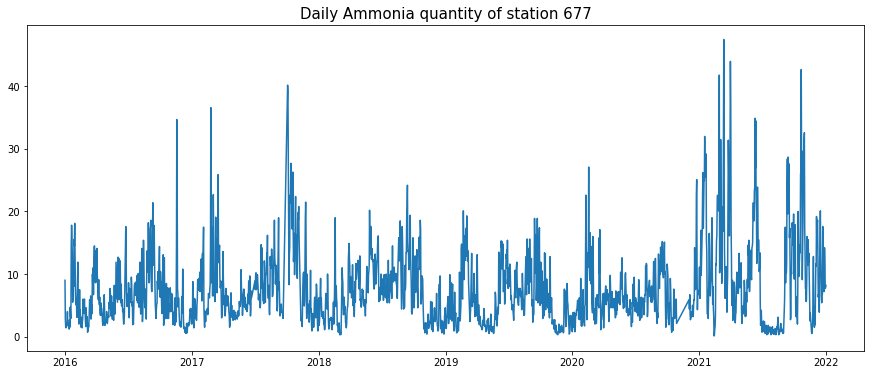

In [64]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677['AQ_nh3'])
plt.title('Daily Ammonia quantity of station 677',fontsize=15);

In [65]:
nh3_677_weekly = nh3_677.resample('W').mean()

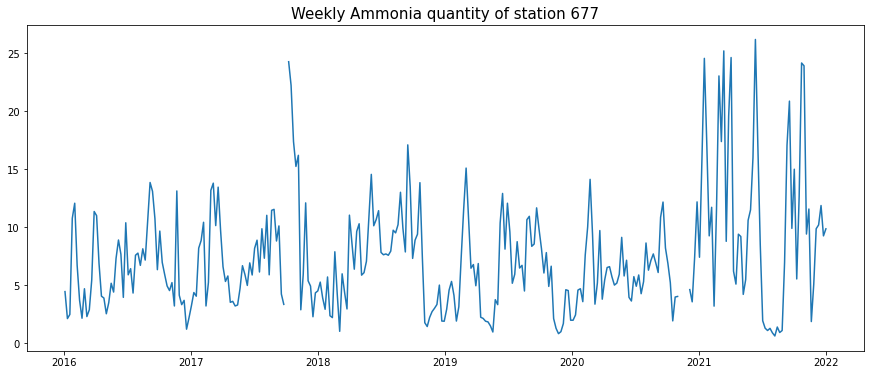

In [66]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677_weekly['AQ_nh3'])
plt.title('Weekly Ammonia quantity of station 677',fontsize=15);

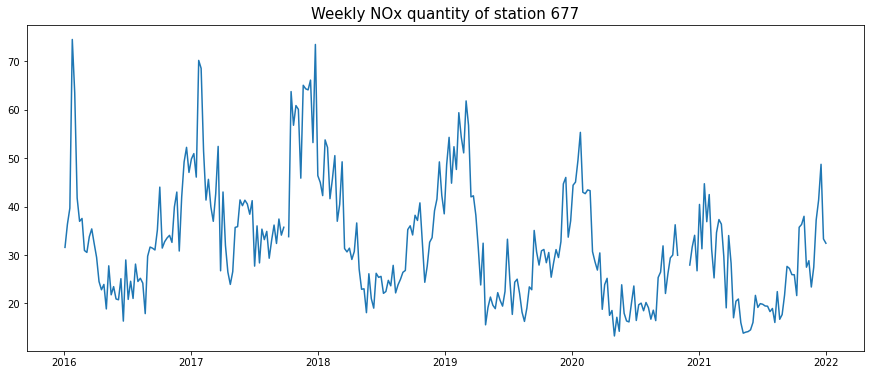

In [67]:
plt.figure(figsize=(15,6))
plt.plot(nh3_677_weekly['AQ_no2'])
plt.title('Weekly NOx quantity of station 677',fontsize=15);

### Air Quality: NOx

In [68]:
high_pol_station = df[df['AQ_nox'] != 0].groupby(['IDStations']).mean()[['AQ_nox']]\
.sort_values('AQ_nox', ascending=False)
high_pol_station.head()

,AQ_nox
IDStations,
652,138.870283
501,114.686362
539,99.108396
548,91.103054
674,89.562026


In [69]:
high_pol_station.tail()

,AQ_nox
IDStations,
1274,22.190234
571,21.009926
STA.IT1921A,18.918915
681,7.717745
STA.IT2074A,6.801675


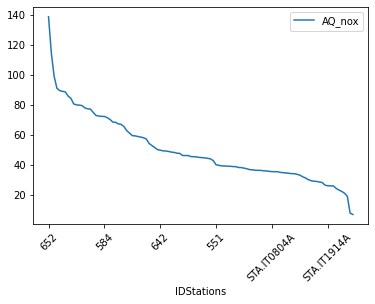

In [70]:
high_pol_station.plot()
plt.xticks(rotation=45);

#### Time series linear model for station 652

In [71]:
def station_daily_nox(station):
    plt.figure(figsize=(15,6))
    df_nox = extract_aq_df('nox',station)
    plt.plot(df_nox['AQ_nox'], color='royalblue')
    plt.title(f'Weekly NOx quantity of station {station}',fontsize=18)
    plt.ylabel('NOx', fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.axhline(df_nox['AQ_nox'].mean(),color='salmon');

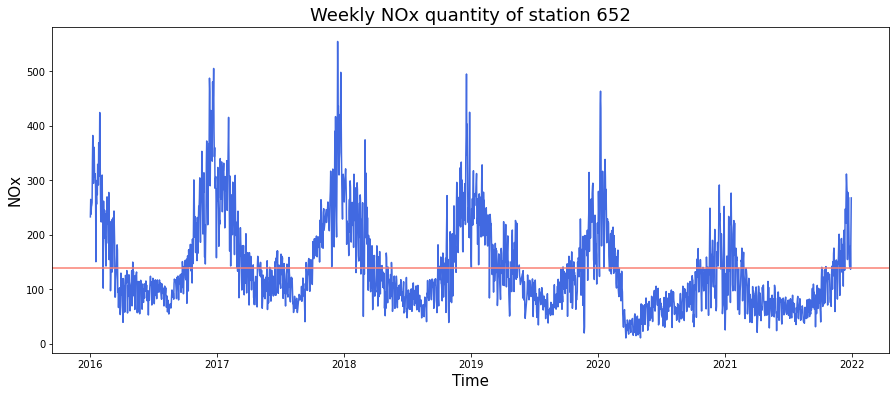

In [72]:
# NOx quantity of station 652
station_daily_nox('652')

Autocorrelation additional information: 
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/m
- https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Parial Autocorrelation additional information:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

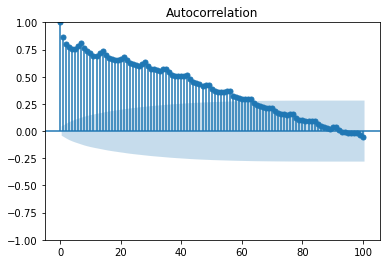

In [73]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=100);

(0.0, 20.0)

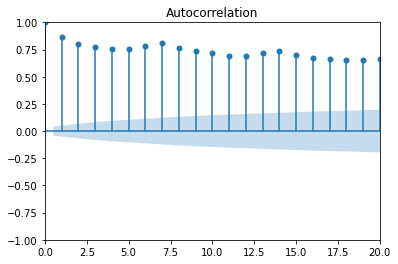

In [74]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=400);
plt.xlim(0,20)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


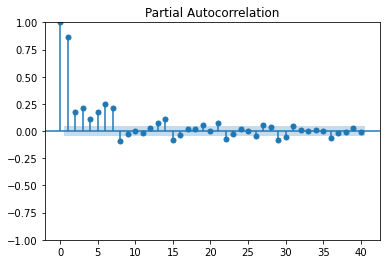

In [75]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('nox','652')['AQ_nox'],lags=40);

In [76]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [77]:
# adfuller for checking the trend of station's 652 data
interpret_dftest(adfuller(extract_aq_df('nox','652')['AQ_nox'].dropna()))
# No trend

Test Statistic   -3.447531
p-value           0.009441
dtype: float64

In [78]:
def train_test_time_series(station, quality,test_size=0.1):
    train, test = train_test_split(extract_aq_df(quality,station)[f'AQ_{quality}'],
                                       test_size=test_size,
                                       shuffle=False)
    # Fix freq of data
    train.index = train.index.to_period('d')
    test.index = test.index.to_period('d')
    return train, test

In [79]:
train, test = train_test_time_series('652', 'nox',test_size=0.05) 

In [80]:
train.shape, test.shape

((2049,), (108,))

In [81]:
train.tail()

Time
2021-09-10    101.50
2021-09-11     78.19
2021-09-12     67.15
2021-09-13    109.40
2021-09-14     91.73
Freq: D, Name: AQ_nox, dtype: float64

In [82]:
def fit_preds(stat_model, test, show_aic=True, show_mse=True):
    model = stat_model.fit()
    # preds = model.predict(start=train.shape[0], end=(train.shape[0]+test.shape[0]-1))
    preds = model.predict(start=test.index[0], end=test.index[-1])
    if show_aic:
        print(f'AIC: {model.aic}')
    if show_mse:
        print(f'MSE: {mean_squared_error(test, preds)}')
    return preds, model.aic, mean_squared_error(test, preds)

In [83]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(10,0,10))
preds = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 20426.190557941904
MSE: 3249.735923551522


In [84]:
def station_graph(train, test, preds,station):
    # Plot data.
    plt.figure(figsize=(10,6))

    # Plot training data in blue.
    #plt.plot(train, color = 'royalblue')
    sns.lineplot(x=train.index.to_timestamp(), y=train, color = 'royalblue')

    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange')

    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green')

    plt.title(f'NOx quantity of station {station}',fontsize=18)
    plt.ylabel('NOx', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.show();

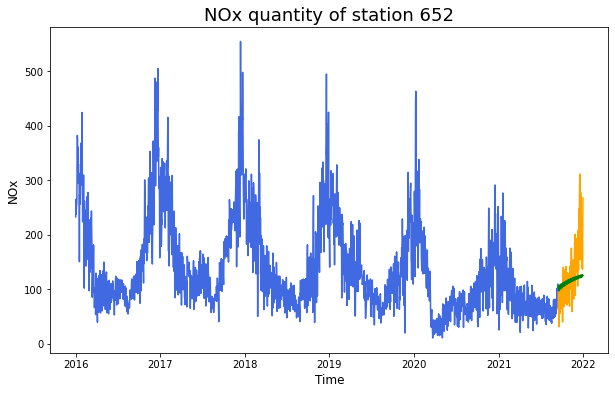

In [85]:
station_graph(train, test, preds[0],'652')

In [86]:
# Manual Gridsearch
p_list = [p for p in range(6,10)]
d_list = [0, 1]
q_list = [q for q in range(6,10)]
manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
count = 0
for p in p_list:
    for d in d_list:
        for q in q_list:
            ar1 = ARIMA(endog=train, order=(p,d,q))
            preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
            manual_grid.loc[count] = [p, d, q, aic, mse]
            count += 1

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

In [87]:
manual_grid.sort_values('mse').head(10)

,p,d,q,aic,mse
18,8.0,0.0,8.0,20421.192271,3131.433324
26,9.0,0.0,8.0,20425.767966,3134.724902
27,9.0,0.0,9.0,20422.122378,3316.109884
0,6.0,0.0,6.0,20470.080954,3351.673203
9,7.0,0.0,7.0,20456.101769,3450.973592
16,8.0,0.0,6.0,20508.092173,3626.832648
11,7.0,0.0,9.0,20444.536899,3636.841274
24,9.0,0.0,6.0,20493.019923,3677.675062
17,8.0,0.0,7.0,20430.683126,4109.760459
8,7.0,0.0,6.0,20452.242686,4205.481335


In [88]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,8))
preds = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 20421.192271111875
MSE: 3131.433323838929


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
preds

(2021-09-15    101.654495
 2021-09-16    106.155310
 2021-09-17    107.179074
 2021-09-18    100.352964
 2021-09-19    100.094758
                  ...    
 2021-12-27    129.616543
 2021-12-28    126.556241
 2021-12-29    124.868577
 2021-12-30    128.446229
 2021-12-31    128.830004
 Freq: D, Name: predicted_mean, Length: 108, dtype: float64,
 20421.192271111875,
 3131.433323838929)

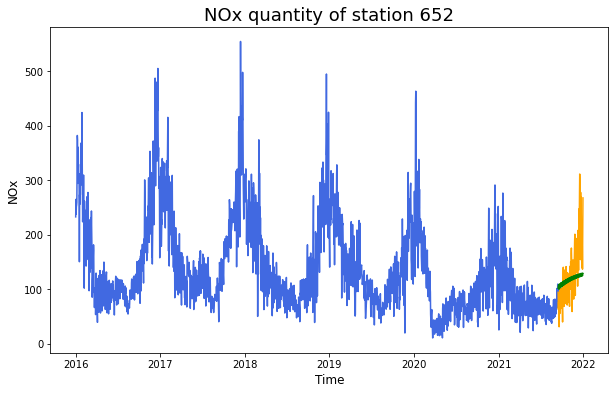

In [90]:
station_graph(train, test, preds[0],'652')

In [91]:
def test_pred_graph(test,preds,station):
    # Plot data.
    plt.figure(figsize=(10,6))
    # Plot testing data in orange.
    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange')
    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green')
    plt.title(label = f'Station {station}', fontsize=18)
    plt.show();

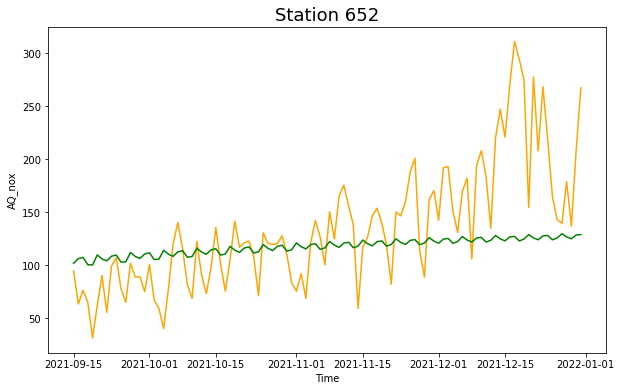

In [92]:
test_pred_graph(test,preds[0],'652')

### Air quaility: PM10

In [93]:
def station_daily_pm10(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm10', '1264')
    plt.plot(df_aq['AQ_pm10'], color='royalblue')
    plt.title(f'Daily PM10 quantity of station {station}',fontsize=18)
    plt.ylabel('PM10', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm10'].mean(),color='salmon');

In [94]:
extract_aq_df('pm10','1264').head()

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0
2016-01-02,1264,46.167852,9.87921,290,73.0,63.0,0.0,0.0,101.70,38.84,...,0.6298,0.8372,1.72,0.3911,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-03,1264,46.167852,9.87921,290,44.0,39.0,0.0,0.0,66.26,32.34,...,0.6424,0.8384,1.72,0.3916,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-04,1264,46.167852,9.87921,290,31.0,29.0,0.0,0.0,63.31,31.67,...,0.6545,0.8396,1.72,0.3923,0.3832,5.892,3.997,1.234,112.0,17.0
2016-01-05,1264,46.167852,9.87921,290,27.0,26.0,0.0,0.0,75.53,33.33,...,0.6660,0.8409,1.72,0.3931,0.3832,5.892,3.997,1.233,112.0,17.0


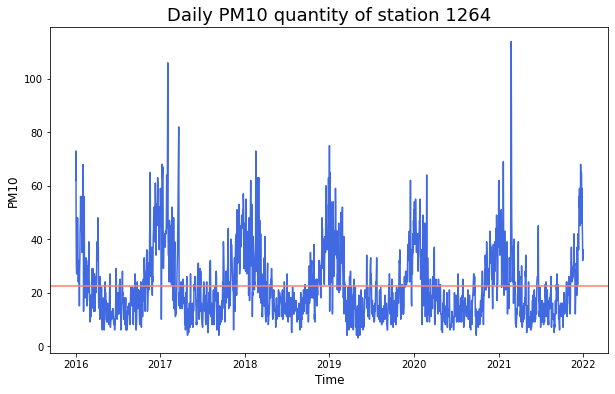

In [95]:
station_daily_pm10('1264')

In [96]:
train, test = train_test_time_series('1264', 'pm10',test_size=0.04) 

In [97]:
train.shape, test.shape

((2026,), (85,))

In [98]:
test.index[0] - test.index[-1]

<-84 * Days>

In [99]:
test.index[-1]

Period('2021-12-31', 'D')

In [100]:
test.index

PeriodIndex(['2021-10-08', '2021-10-09', '2021-10-10', '2021-10-11',
             '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15',
             '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19',
             '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23',
             '2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27',
             '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31',
             '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
             '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
             '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
             '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
             '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
             '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
             '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
             '2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02',
             '2021-12-03', '2021-1

In [101]:
# Fit model ARIMA
ar = ARIMA(endog=train, order=(30,1,30))
preds = fit_preds(ar, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 13823.780793405367
MSE: 536.4560004890849


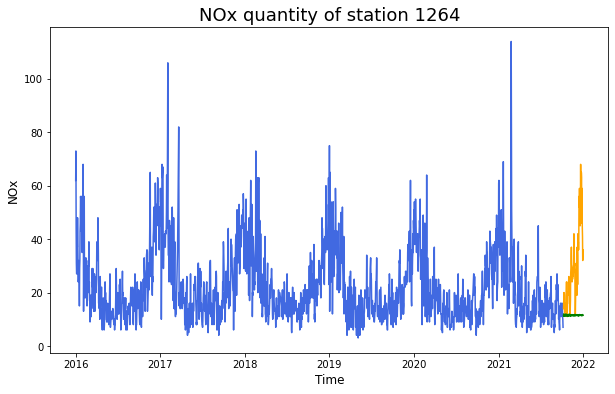

In [102]:
station_graph(train, test, preds[0],'1264')

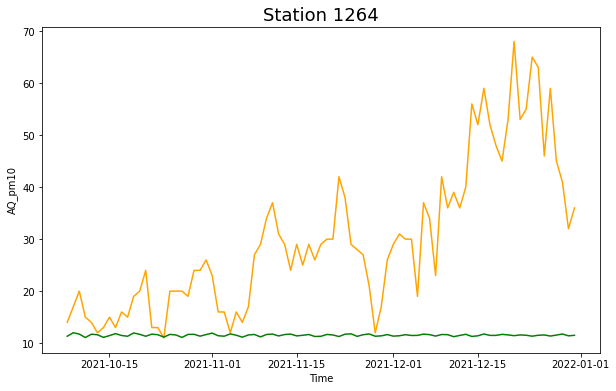

In [103]:
test_pred_graph(test,preds[0],'1264')

In [104]:
def station_weekly_pm10(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm10', station).resample('W').mean()
    plt.plot(df_aq['AQ_pm10'], color='royalblue')
    plt.title(f'Weekly PM10 quantity of station {station}',fontsize=18)
    plt.ylabel('PM10', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm10'].mean(),color='salmon');

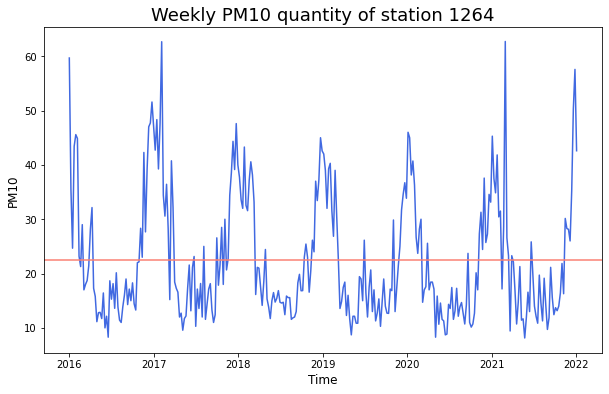

In [105]:
station_weekly_pm10('1264')

### Air quaility: PM2.5

In [106]:
# Station that have the data about amount of PM2.5 in the air 
df_time[df_time['AQ_pm25'] != 0]['IDStations'].value_counts().head()

1297           2152
627            2146
592            2135
STA.IT2121A    2131
583            2130
Name: IDStations, dtype: int64

In [107]:
def station_daily_pm25(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm25', station)
    plt.plot(df_aq['AQ_pm25'], color='royalblue')
    plt.title(f'Daily PM2.5 quantity of station {station}',fontsize=18)
    plt.ylabel('PM2.5', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm25'].mean(),color='salmon');

In [108]:
def station_weekly_pm25(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('pm25', station).resample('W').mean()
    plt.plot(df_aq['AQ_pm25'], color='royalblue')
    plt.title(f'Weekly PM2.5 quantity of station {station}',fontsize=18)
    plt.ylabel('PM2.5', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_pm25'].mean(),color='salmon');

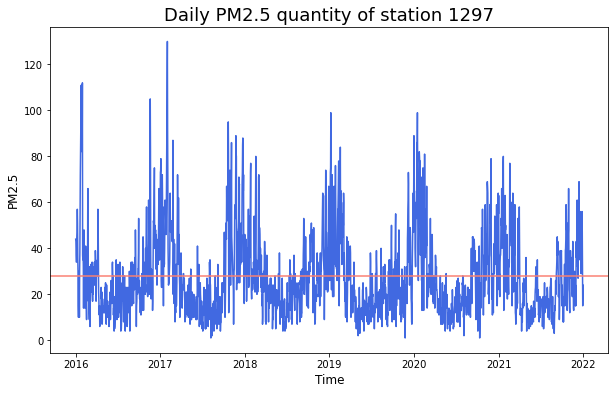

In [109]:
station_daily_pm25('1297')

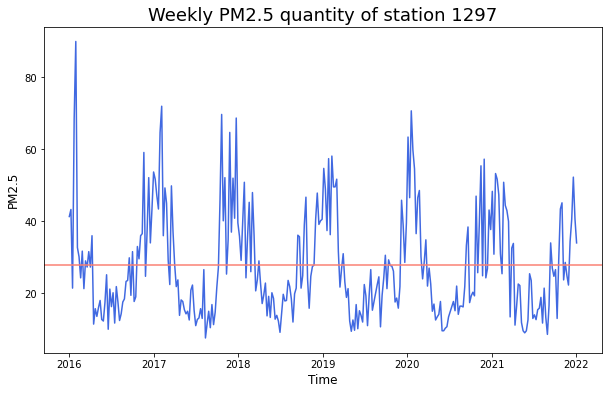

In [110]:
station_weekly_pm25('1297')

### Air quality: NO2

In [111]:
high_no2_station = df[df['AQ_no2'] != 0].groupby(['IDStations']).mean()[['AQ_no2']]\
.sort_values('AQ_no2', ascending=False)
high_no2_station.head()

,AQ_no2
IDStations,
501,56.814509
652,52.983928
529,51.737712
548,47.769415
539,46.317854


In [112]:
def station_daily_no2(station):
    plt.figure(figsize=(10,6))
    df_aq = extract_aq_df('no2', station)
    plt.plot(df_aq['AQ_no2'], color='royalblue')
    plt.title(f'Weekly NO2 quantity of station {station}',fontsize=18)
    plt.ylabel('NO2', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.axhline(df_aq['AQ_no2'].mean(),color='salmon');

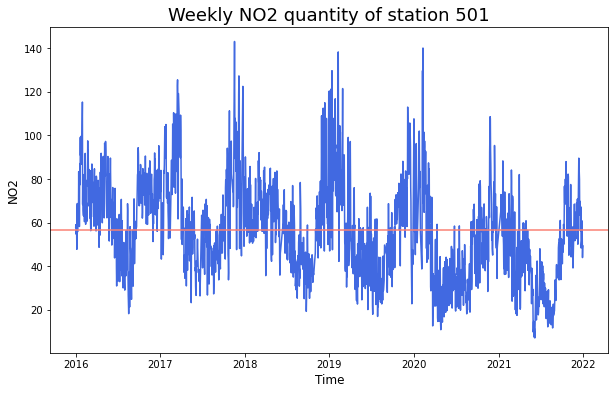

In [113]:
station_daily_no2('501')